In [1]:
### useful to reload automatically a module if its code has been modified 
%load_ext autoreload
%autoreload 2
%matplotlib inline

import sys 
sys.path.append('..')

import warnings
warnings.filterwarnings('ignore')

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from skimage import io
from skimage.measure import find_contours
from tqdm import tqdm

from sources.utils import plot_stack

# LGG Segmentation Kaggle dataset 

The LGG (lower-grade gliomas) segmentation dataset from Kaggle can be found here https://www.kaggle.com/mateuszbuda/lgg-mri-segmentation

Glioma is a type of cerebral tumor. 

The dataset is composed of MR brain images of 110 patients. 

3 different sequences are concatenated in ```.tif``` files :
- pre-contrast
- FLAIR : "Fluid Attenuated Inversion Recovery" is a famous imaging technique to detect tumor location in the brain.
- post-contrast

For each MR images, manual **segmentation masks** of the tumor from the FLAIR sequences are also provided.

### Original dataframe 

Let's have a quick look on the dataframe and the distribution of the different features :

In [3]:
# read the pandas dataframe
data_path = '../data/kaggle_3m/'
df = pd.read_csv(os.path.join(data_path, 'data.csv'))

print('Number of patients : ', len(df))
print('Number of features : ', df.shape[1]-1)

Number of patients :  110
Number of features :  17


In [4]:
df.head()

,Patient,RNASeqCluster,MethylationCluster,miRNACluster,CNCluster,RPPACluster,OncosignCluster,COCCluster,histological_type,neoplasm_histologic_grade,tumor_tissue_site,laterality,tumor_location,gender,age_at_initial_pathologic,race,ethnicity,death01
0,TCGA_CS_4941,2.0,4.0,2,2.0,NaN,3.0,2,1.0,2.0,1.0,3.0,2.0,2.0,67.0,3.0,2.0,1.0
1,TCGA_CS_4942,1.0,5.0,2,1.0,1.0,2.0,1,1.0,2.0,1.0,3.0,2.0,1.0,44.0,2.0,NaN,1.0
2,TCGA_CS_4943,1.0,5.0,2,1.0,2.0,2.0,1,1.0,2.0,1.0,1.0,2.0,2.0,37.0,3.0,NaN,0.0
3,TCGA_CS_4944,NaN,5.0,2,1.0,2.0,1.0,1,1.0,1.0,1.0,3.0,6.0,2.0,50.0,3.0,NaN,0.0
4,TCGA_CS_5393,4.0,5.0,2,1.0,2.0,3.0,1,1.0,2.0,1.0,1.0,6.0,2.0,39.0,3.0,NaN,0.0


Each patient is represented by its ID (first column). 

The 17 feature properties are of different types : float, integer, and binary integer. They include tumor genomic clusters and other metadata related to the patient (age, gender, ...).

Let's have a look on their distribution : 

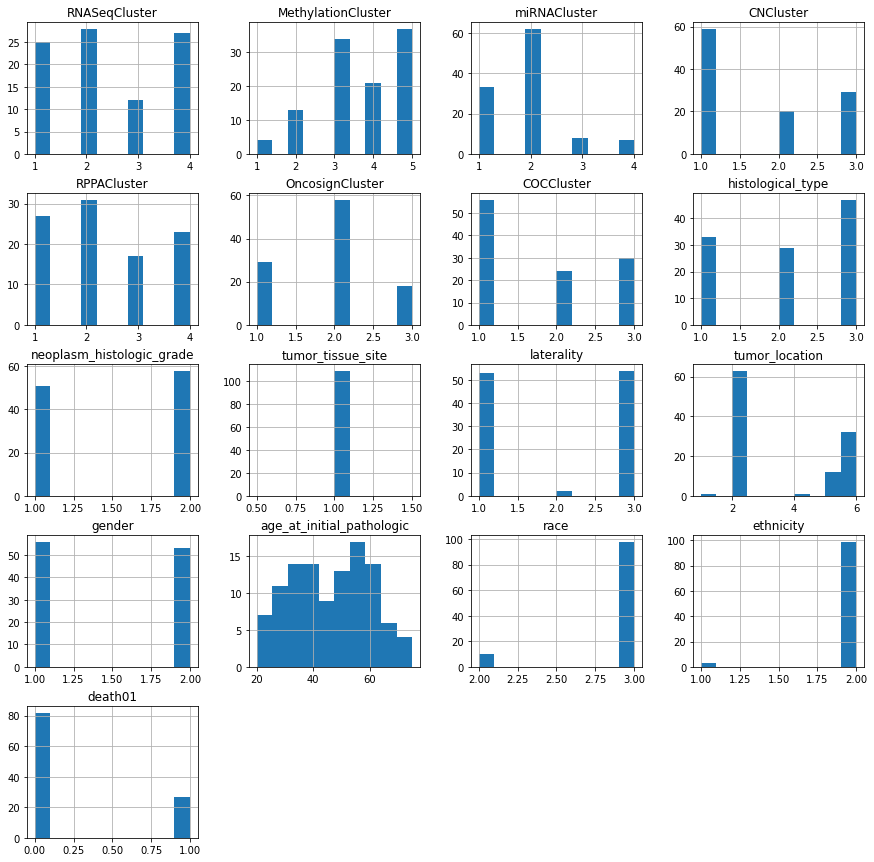

In [6]:
hist = df.hist(figsize=(15, 15))

Some of the attributes are well balanced (e.g. gender, age) but others less. 

If some of the imbalanced properties are strongly related to tumor evolution or localization (e.g. 'tumor_location'), our deep-learning model will probably need more data to better generalize on a test set. 

### Dataframe for image segmentation

Now, let's create a new dataframe describing all available images/masks, especially their path location with their associated patient ID.

Each patient has its own directory containing MR images/masks with the following naming convention:
`TCGA_<institution-code>_<patient-id>_<slice-number>.tif`.
 Masks have a `_mask` suffix.

We will also add a new column **"has_tumor"** with binary integers to provide information about the presence of a segmented tumor or not in the corresponding image (note that if the corresponding mask is the zero matrix, then no tumor is present)


In [5]:
# create new dataframe
image_df = pd.DataFrame(columns=['patient_id', 'image_id', 'image_path', 'mask_path', 'has_tumor'])

# patient directories
patient_dir = [d for d in os.listdir(data_path) if os.path.isdir(os.path.join(data_path, d))]
patient_dir.sort(key=lambda x:x[8:12]) # sort according to patient-ID

# if an image contains a non-empty tumor mask or not
def has_tumor(mask_path):
    mask = io.imread(mask_path) # S'il y a au moins un tache blanche il ya une tumeur.
    return int(np.sum(mask.ravel()) > 0)

# fill dataframe 
for d in tqdm(patient_dir):
    parent_dir = os.path.join(data_path, d)

    image_files = [f for f in os.listdir(parent_dir) if f.endswith('.tif') and not f.endswith('mask.tif')]
    image_key = lambda x:int(x[len(d)+1:].replace('.tif',''))
    image_files.sort(key=image_key) # sort according to ID of the image
    
    mask_files = [f for f in os.listdir(parent_dir) if f.endswith('mask.tif')]
    mask_key = lambda x:int(x[len(d)+1:].replace('_mask.tif',''))
    mask_files.sort(key=mask_key) # sort according to ID of the image
    
    for i, (image_file, mask_file) in enumerate(zip(image_files, mask_files)):
        if image_key(image_file) == mask_key(mask_file):
            image_df = image_df.append({'patient_id': d, 
                                        'image_id': image_key(image_file),
                                        'image_path': os.path.join(parent_dir, image_file),
                                        'mask_path': os.path.join(parent_dir, mask_file),
                                        'has_tumor': has_tumor(os.path.join(parent_dir, mask_file))},
                                       ignore_index=True)
        else:
            print("No corresponding mask found for image : ", image_file)

# save dataframe
image_df.to_csv('image_data.csv')

100%|██████████| 110/110 [00:32<00:00,  3.40it/s]


In [6]:
image_df = pd.read_csv('image_data.csv')    
print('Total number of images : ', len(image_df))
image_df.head()

Total number of images :  3929


,Unnamed: 0,patient_id,image_id,image_path,mask_path,has_tumor
0,0,TCGA_CS_4941_19960909,1,../data/kaggle_3m/TCGA_CS_4941_19960909/TCGA_C...,../data/kaggle_3m/TCGA_CS_4941_19960909/TCGA_C...,0
1,1,TCGA_CS_4941_19960909,2,../data/kaggle_3m/TCGA_CS_4941_19960909/TCGA_C...,../data/kaggle_3m/TCGA_CS_4941_19960909/TCGA_C...,0
2,2,TCGA_CS_4941_19960909,3,../data/kaggle_3m/TCGA_CS_4941_19960909/TCGA_C...,../data/kaggle_3m/TCGA_CS_4941_19960909/TCGA_C...,0
3,3,TCGA_CS_4941_19960909,4,../data/kaggle_3m/TCGA_CS_4941_19960909/TCGA_C...,../data/kaggle_3m/TCGA_CS_4941_19960909/TCGA_C...,0
4,4,TCGA_CS_4941_19960909,5,../data/kaggle_3m/TCGA_CS_4941_19960909/TCGA_C...,../data/kaggle_3m/TCGA_CS_4941_19960909/TCGA_C...,0


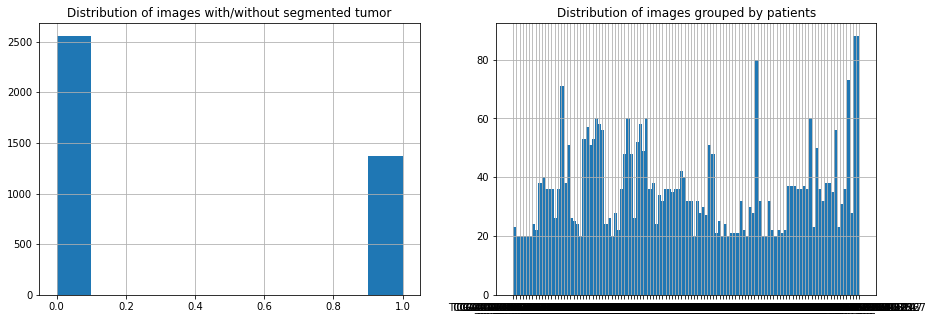

In [7]:
fig = plt.figure(figsize=(15, 5))

plt.subplot(121)
hist = image_df['has_tumor'].hist()
plt.title("Distribution of images with/without segmented tumor")

plt.subplot(122)
hist = image_df['patient_id'].hist(bins=len(image_df['patient_id'].unique()))
plt.title("Distribution of images grouped by patients")

plt.show()

### Data visualization

In [9]:
# read MR images/masks
def read_mri(patient_id):
    sub_df = image_df[image_df.patient_id == patient_id].reset_index()
    dim = len(sub_df)
    image_stack = np.zeros((dim, 256, 256, 3), dtype='uint8')
    mask_stack = np.zeros((dim, 256, 256), dtype='uint8')
    for i in range(dim):
        image_stack[i] = io.imread(sub_df.image_path[i])
        mask_stack[i] = io.imread(sub_df.mask_path[i])
    return image_stack, mask_stack, list(sub_df[sub_df.has_tumor == 1].index)

# choose a patient
patient_index = 3
patient_id = image_df.patient_id.unique()[patient_index]

# read mri
image_stack, mask_stack, has_tumor_indices = read_mri(patient_id)

print("Patient ID : ", patient_id)
print("MRI stack : shape =", image_stack.shape, ", dtype =", image_stack.dtype)
print("Mask stack : shape =", mask_stack.shape, ", dtype =", mask_stack.dtype)
print("Indices of slices with segmented tumor :", has_tumor_indices)

Patient ID :  TCGA_CS_4944_20010208
MRI stack : shape = (20, 256, 256, 3) , dtype = uint8
Mask stack : shape = (20, 256, 256) , dtype = uint8
Indices of slices with segmented tumor : [5, 6, 7, 8, 9, 10, 11, 12, 13]


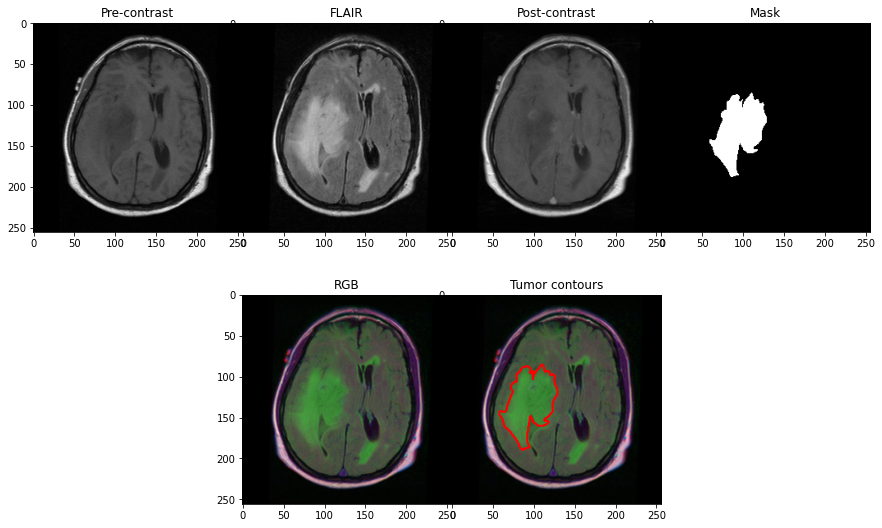

In [14]:
# choose a slice from the stack
slice_index = 11
img_slice = image_stack[slice_index]
mask_slice = mask_stack[slice_index]

fig = plt.figure(figsize=(15, 10))

plt.subplot(241)
plt.imshow(img_slice[:, :, 0], 'gray'), plt.title("Pre-contrast")
plt.subplot(242)
plt.imshow(img_slice[:, :, 1], 'gray'), plt.title("FLAIR")
plt.subplot(243)
plt.imshow(img_slice[:, :, 2], 'gray'), plt.title("Post-contrast")
plt.subplot(244)
plt.imshow(mask_slice, 'gray'), plt.title("Mask")
plt.subplot(246)
plt.imshow(img_slice), plt.title("RGB")
plt.subplot(247)
plt.imshow(img_slice), 
contours = find_contours(mask_slice, 1)
for contour in contours:
    plt.plot(contour[:, 1], contour[:, 0], linewidth=2, c='r')
plt.title("Tumor contours")

plt.subplots_adjust(wspace=0, hspace=0)
plt.show()

### 3D plotly viewer

warning: Pleas erase image before git push, it's huge.

In [ ]:
plot_stack(image_stack[:, :, :, 1])

In [ ]:
plot_stack(mask_stack)

In [ ]:
# end: next book to come